In [33]:
import requests
import json
from random import random

# Define the base URL of the API
base_url = "http://localhost:3000"

# Send a vector to the '/insert' endpoint
def insert_vector(vector_data):
    url = f"{base_url}/vector/insert"
    headers = {'Content-Type': 'application/json'}
    response = requests.post(url, headers=headers, data=json.dumps(vector_data))
    
    if response.status_code == 200:
        print(f"Response from '/insert': {response.json()}")
    else:
        print(f"Error: {response.status_code}")

def insert_batch_vector(vector_data):
    url = f"{base_url}/vector/insert_batch"
    headers = {'Content-Type': 'application/json'}
    response = requests.post(url, headers=headers, data=json.dumps(vector_data))
    
    if response.status_code == 200:
        print(f"Response from '/insert': {response.json()}")
    else:
        print(f"Error: {response.status_code}")

# Request metadata from the '/metadata' endpoint
def get_metadata():
    url = f"{base_url}/metadata"
    headers = {'Content-Type': 'application/json'}
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        return json.loads(response.json().replace("(", "[").replace(")", "]"))
    else:
        print(f"Error: {response.status_code}")

# KNN Query function
def knn_query(vector, k):
    url = f"{base_url}vector/knn"
    payload = {"vector": vector, "k": k}
    headers = {'Content-Type': 'application/json'}

    response = requests.get(url, headers=headers, data=json.dumps(payload))
    
    if response.status_code == 200:
        print(f"Response from 'vector/knn': {response.json()}")
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None
def get_vectors_by_partition(partition_ids):
    url = f"{base_url}/vector/from_partitions"
    headers = {'Content-Type': 'application/json'}
    
    payload = {
        "ids": partition_ids
    }
    
    response = requests.get(url, headers=headers, data=json.dumps(payload))
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None
def get_edges_for_partition(partition_id):
    url = f"{base_url}/graph/intra/by_partitions"
    headers = {'Content-Type': 'application/json'}
    
    payload = {
        "ids": [partition_id]
    }
    
    response = requests.get(url, headers=headers, data=json.dumps(payload))
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None
def get_inter_edges_for_partition(partition_id):
    url = f"{base_url}/graph/inter/by_partitions"
    headers = {'Content-Type': 'application/json'}
    
    payload = {
        "ids": [partition_id]
    }
    
    response = requests.get(url, headers=headers, data=json.dumps(payload))
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

# Example: Sending a vector to the API
vector_data = {
    "vector": [random(), random()]  # Example vector data
}

# Example: Requesting metadata
# get_metadata()
def generate_clusters(threshold):
    url = f"{base_url}/cluster/new"
    headers = {'Content-Type': 'application/json'}
    
    payload = {
        "threshold": threshold
    }
    
    response = requests.put(url, headers=headers, data=json.dumps(payload))
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None
def get_clusters(threshold):
    url = f"{base_url}/cluster"
    headers = {'Content-Type': 'application/json'}
    
    payload = {
        "threshold": threshold
    }
    
    response = requests.get(url, headers=headers, data=json.dumps(payload))
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

In [3]:
from random import uniform, gauss
from math import sqrt
from dataclasses import dataclass
from typing import List

@dataclass
class Cluster:
    center: List[float]
    radius: float
    num_points: int

def generate_random_points_nd(center: List[float], radius: float, num_points: int) -> List[List[float]]:
    """
    Generates random points within a given radius around a center point in n-dimensional space.
    """
    n = len(center)
    points = []

    for _ in range(num_points):
        # Generate a random direction
        random_direction = [gauss(0, 1) for _ in range(n)]
        norm = sqrt(sum(x ** 2 for x in random_direction))
        unit_vector = [x / norm for x in random_direction]
        
        # Generate a random distance within the radius
        random_distance = uniform(0, radius)
        
        # Compute the random point
        random_point = [center[i] + random_distance * unit_vector[i] for i in range(n)]
        points.append(random_point)

    return points

In [4]:
insert_vector({
    "vector": [random(), random()]  # Example vector data
})

Response from '/insert': Vector received


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

def plot_partition_graph(partitions, edges, meta_data, inter_partition_edges=None, cluster_data=None):
    """
    Plot a graph where nodes represent vectors in partitions and edges represent connections between them.

    Args:
        partitions: List of tuples [(PartitionId: str, [(VectorId: str, [float, float])])]
        edges: List of lists of tuples [(VectorId: str, VectorId: str, weight: float)]
        meta_data: List of tuples [(PartitionId: str, size: int, centroid: [float, float])]
        inter_partition_edges: List of tuples [(VectorId: str, VectorId: str, weight: float)]
        cluster_data: Dict[str, List[str]] - Mapping of Cluster Ids to lists of Vector Ids
    """
    plt.figure(figsize=(12, 8))

    # Generate distinct colors for each partition
    num_partitions = len(partitions)
    colors = plt.cm.get_cmap('tab20', num_partitions)

    # Extract centroids and colors for partitions
    centroids = np.array([centroid for _, _, centroid in meta_data])
    partition_colors = [colors(i) for i in range(num_partitions)]

    # Create a KDTree for efficient nearest neighbor search
    tree = KDTree(centroids)

    # Set up grid points for background coloring
    vector_coords = np.concatenate([np.array([vector_data[1] for vector_data in vectors]) for _, vectors in partitions])
    x_min, x_max = vector_coords[:, 0].min(), vector_coords[:, 0].max()
    y_min, y_max = vector_coords[:, 1].min(), vector_coords[:, 1].max()

    x_dist = (x_max - x_min) * 0.1
    x_min, x_max = x_min - x_dist, x_max + x_dist
    y_dist = (y_max - y_min) * 0.1
    y_min, y_max = y_min - y_dist, y_max + y_dist

    x_vals = np.linspace(x_min, x_max, 500)
    y_vals = np.linspace(y_min, y_max, 500)
    xv, yv = np.meshgrid(x_vals, y_vals)
    grid_points = np.c_[xv.ravel(), yv.ravel()]

    # Find nearest centroid for each grid point
    _, indices = tree.query(grid_points)
    
    # Color the background based on the nearest centroid
    background_colors = np.array([partition_colors[idx] for idx in indices])
    plt.scatter(grid_points[:, 0], grid_points[:, 1], c=background_colors, marker='s', s=1, alpha=0.1)

    # Plot partition labels behind everything
    for partition_index, (partition_id, _, centroid) in enumerate(meta_data):
        plt.text(
            centroid[0], centroid[1], partition_id, 
            fontsize=12, color='gray', alpha=0.3, 
            ha='center', va='center', zorder=-1
        )



    # Plot nodes for each partition
    node_positions = {}
    for partition_index, (partition_id, vectors) in enumerate(partitions):
        partition_color = partition_colors[partition_index]
        vector_coords = np.array([vector_data[1] for vector_data in vectors])
        if len(vector_coords) > 0:
            plt.scatter(
                vector_coords[:, 0], 
                vector_coords[:, 1], 
                s=40, 
                c=[partition_color], 
                edgecolors='k', 
                marker='x', 
                label=f"Partition {partition_id}"
            )
            for vector_id, coord in zip([vec[0] for vec in vectors], vector_coords):
                node_positions[vector_id] = coord
    
    
    # Render cluster circles
    if cluster_data:
        cluster_colors = plt.cm.get_cmap('rainbow', len(cluster_data))
        for i, (cluster_id, vector_ids) in enumerate(cluster_data.items()):
            cluster_color = cluster_colors(i)
            for vector_id in vector_ids:
                if vector_id in node_positions:
                    pos = node_positions[vector_id]
                    plt.scatter(
                        pos[0], pos[1], 
                        s=100, 
                        color=cluster_color, 
                        edgecolors='none', 
                        alpha=0.3, 
                        marker='o'
                    )

    # Plot centroids from meta_data
    for partition_index, (partition_id, size, centroid) in enumerate(meta_data):
        plt.scatter(
            centroid[0], centroid[1], 
            s=max(10, size * 5), 
            c=[partition_colors[partition_index]], 
            edgecolors='white', 
            marker='o', 
            label=f"Centroid for {partition_id}"
        )

    # Plot edges within partitions
    for partition_edges in edges:
        for vector_id1, vector_id2, weight in partition_edges:
            if vector_id1 in node_positions and vector_id2 in node_positions:
                pos1 = node_positions[vector_id1]
                pos2 = node_positions[vector_id2]
                plt.plot(
                    [pos1[0], pos2[0]], 
                    [pos1[1], pos2[1]], 
                    'k--', 
                    linewidth=max(0.5, weight * 0.1), 
                    alpha=0.7
                )

    # Plot inter-partition edges (solid lines)
    if inter_partition_edges:
        for vector_id1, vector_id2, weight in inter_partition_edges:
            if vector_id1 in node_positions and vector_id2 in node_positions:
                pos1 = node_positions[vector_id1]
                pos2 = node_positions[vector_id2]
                plt.plot(
                    [pos1[0], pos2[0]], 
                    [pos1[1], pos2[1]], 
                    color='purple', 
                    linewidth=max(0.5, weight * 0.1), 
                    alpha=0.9
                )

    plt.title("Partition Graph with Weighted Edges and Metadata Centroids")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


In [ ]:
get_metadata()

[['b5b0cb44-4b48-49eb-bd48-8e61047a2a99', 1, [0.6718139, 0.04265732]]]

In [ ]:
from functional import seq
meta_data = get_metadata()
partitions = get_vectors_by_partition(seq(meta_data).map(lambda x: x[0]).list())
edges = seq(partitions).map(lambda x: get_edges_for_partition(x[0])).list()
inter_edges = seq(partitions).map(lambda x: get_inter_edges_for_partition(x[0])).flatten().list()
plot_partition_graph(partitions, edges, meta_data, inter_edges)

C:\Users\hasin\AppData\Local\Temp\ipykernel_34952\3131095296.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_partitions)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1200x800 with 0 Axes>

# Large Input test

In [ ]:
vectors = [[random(), random()] for i in range(10_000)]

In [89]:
# Define clusters
# clusters = [
#     Cluster(center=[0.5, 0.5], radius=0.05, num_points=40),  # Dense cluster
#     Cluster(center=[0., 0.], radius=.5, num_points=100*4),    # Sparse cluster
#     Cluster(center=[0.25, 0.75], radius=0.15, num_points=50*4),   # Medium density
#     Cluster(center=[0.9, 0.1], radius=0.1, num_points=80*4),    # Mixed density
# ]

clusters = [
    Cluster(center=[1.5, 0.5], radius=0.5, num_points=50),  # Dense cluster
    Cluster(center=[0., 0.], radius=.5, num_points=15),    # Sparse cluster
    Cluster(center=[3.25, 3.75], radius=0.5, num_points=25),   # Medium density
    Cluster(center=[3.1, 1.1], radius=0.5, num_points=30),    # Mixed density
]

# Add a composite cluster with sub-clusters to form a non-circular shape
composite_cluster_centers = [
    # [0.4, 0.4],
    # [0.5, 0.5],
    # [0.6, 0.6],
    # [0.7, 0.7],
]
composite_points = []

for sub_center in composite_cluster_centers:
    points = generate_random_points_nd(sub_center, (0.1**2+0.1**2)**0.5, 50*4)  # Smaller clusters
    composite_points.extend(points)

vectors = []

# Append the composite cluster points
# vectors.extend(composite_points)

# Generate points for regular clusters
for cluster in clusters:
    points = generate_random_points_nd(cluster.center, cluster.radius, cluster.num_points)
    vectors.extend(points)


print(f"Generated {len(vectors)} points including a non-circular composite cluster.")

Generated 120 points including a non-circular composite cluster.


In [90]:
from random import shuffle
shuffle(vectors)
vectors

[[3.4144743197393828, 3.6800432595541666],
 [1.1124658103524645, 0.5935757594890836],
 [1.4774213499605808, 0.48488231062998144],
 [2.922701326512765, 3.897858115259766],
 [-0.16573212419848973, 0.05531795422535834],
 [3.2802752842895253, 3.6631909249619174],
 [1.8583132508744562, 0.5712398512623584],
 [1.542203825908385, 0.07035378489175925],
 [3.237168491626268, 0.8677125861285877],
 [3.4121528901815728, 3.784572910053752],
 [2.7907032618816627, 1.0378965155568265],
 [1.1120873798144237, 0.20362970206040254],
 [3.118029062041557, 1.5356587812182654],
 [3.2851232932936387, 0.9564647442694695],
 [1.497929812553685, 0.5875500035638471],
 [1.065964923000924, 0.42261271645464876],
 [3.3674486062665485, 3.7973142467991505],
 [3.219913474981251, 0.9245933112386657],
 [2.8808195968104586, 1.3891480542064885],
 [0.35544068836802367, 0.1461148613985596],
 [3.3564744069646495, 3.363591551368538],
 [3.077205783153101, 0.8262564506908978],
 [-0.1749672210765944, -0.11291382664688772],
 [3.2534184

In [ ]:
# for i, vector in enumerate(vectors):
#     if i % 5 == 0:
#         plot_partition_influence(get_metadata())

#     insert_vector({
#         "vector": vector  # Example vector data
#     })
# plot_partition_influence(get_metadata())

In [ ]:
vectors[20]

[0.5036588509613689, 0.5413292489263289]

In [91]:
from concurrent.futures import ThreadPoolExecutor
from functional import seq

def get_data():
    meta_data = get_metadata()
    partitions = get_vectors_by_partition(seq(meta_data).map(lambda x: x[0]).list())
    
    with ThreadPoolExecutor() as executor:
        edges_future = executor.map(lambda x: get_edges_for_partition(x[0]), partitions)
        inter_edges_future = executor.map(lambda x: get_inter_edges_for_partition(x[0]), partitions)
    
    edges = list(edges_future)
    inter_edges = list(seq(inter_edges_future).flatten())
    
    return meta_data, partitions, edges, inter_edges

In [97]:
get_data()

([['d9830128-0ad5-4e83-9620-65ed61306675', 25, [3.2321258, 3.8262863]],
  ['7010ffb7-e45d-4bf3-8fa4-791c75dd4737', 30, [3.0635707, 1.1036488]],
  ['6b52bbcf-734e-4b06-a241-ac93796a70a8', 19, [1.2199993, 0.46218702]],
  ['168973a9-5bcd-49b0-8ac5-aea8a9ad95d9', 15, [-0.045557506, -0.03260708]],
  ['ae4136df-36ba-43d5-8e23-18853672798d', 31, [1.61225, 0.5378568]]],
 [['d9830128-0ad5-4e83-9620-65ed61306675',
   [['7c961209-0bcd-46e8-adc1-2b3a4d251cfe', [3.4144742, 3.6800432]],
    ['da54db07-705f-4bbd-92c8-f5f10e1633c7', [2.9227014, 3.8978581]],
    ['5726ed37-8f2b-4241-849f-1d3a610ff80d', [3.2802753, 3.6631908]],
    ['74edafc0-60a5-4d59-ac14-8c44e1dbc964', [3.412153, 3.7845728]],
    ['39328210-1543-412b-a235-f242c36b6629', [3.3674486, 3.7973142]],
    ['59ce9e30-8a20-42cc-9122-9e53577f72fa', [3.3564744, 3.3635914]],
    ['dac1808e-2de3-465c-ad81-68503c6e081e', [3.2900348, 3.7718453]],
    ['7aa4b9f8-58a8-4a13-a8b8-d0772b788206', [2.9517016, 3.816056]],
    ['24372b31-9346-4929-b69a-c1c7

Response from '/insert': Vector received
Response from '/insert': Vector received
Response from '/insert': Vector received
Response from '/insert': Vector received
Response from '/insert': Vector received
Response from '/insert': Vector received


C:\Users\hasin\AppData\Local\Temp\ipykernel_29392\2962347705.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_partitions)
C:\Users\hasin\AppData\Local\Temp\ipykernel_29392\2962347705.py:67: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


<Figure size 1200x800 with 0 Axes>

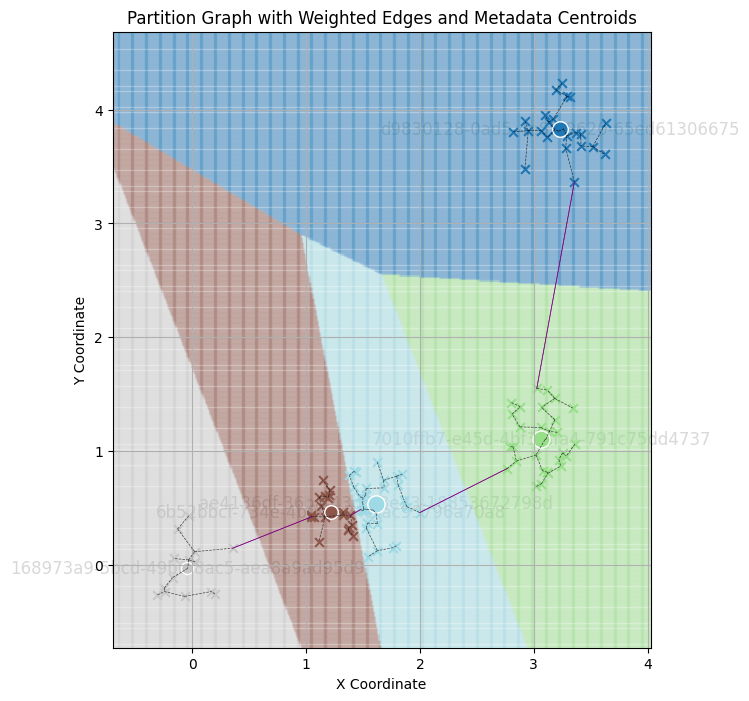

In [92]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.figure import Figure
from functional import seq
batch = []
frames = []  # Store frames for the GIF

for i, vector in enumerate(vectors):
    batch.append({"vector": vector})  # Collect vectors in a batch

    # Send batch when it reaches size 10
    if len(batch) == 20:
        insert_batch_vector(batch)
        batch = []  # Reset the batch
        # meta_data = get_metadata()
        # partitions = get_vectors_by_partition(seq(meta_data).map(lambda x: x[0]).list())
        # edges = seq(partitions).map(lambda x: get_edges_for_partition(x[0])).list()
        # inter_edges = seq(partitions).map(lambda x: get_inter_edges_for_partition(x[0])).flatten().list()

        # # Create a figure for the frame
        # fig: Figure = plt.figure(figsize=(12, 8))
        # plot_partition_graph(partitions, edges, meta_data, inter_edges)
        # plt.close(fig)  # Close the plot to prevent displaying it during the loop
        # frames.append(fig)

# Insert any remaining vectors in the final batch
if batch:
    insert_batch_vector(batch)
    meta_data = get_metadata()
    partitions = get_vectors_by_partition(seq(meta_data).map(lambda x: x[0]).list())
    edges = seq(partitions).map(lambda x: get_edges_for_partition(x[0])).list()
    inter_edges = seq(partitions).map(lambda x: get_inter_edges_for_partition(x[0])).flatten().list()

    # Create a figure for the frame
    fig: Figure = plt.figure(figsize=(12, 8))
    plot_partition_graph(partitions, edges, meta_data, inter_edges)
    plt.close(fig)  # Close the plot to prevent displaying it during the loop
    frames.append(fig)
else:
    meta_data = get_metadata()
    partitions = get_vectors_by_partition(seq(meta_data).map(lambda x: x[0]).list())
    edges = seq(partitions).map(lambda x: get_edges_for_partition(x[0])).list()
    inter_edges = seq(partitions).map(lambda x: get_inter_edges_for_partition(x[0])).flatten().list()

    # Create a figure for the frame
    fig: Figure = plt.figure(figsize=(12, 8))
    plot_partition_graph(partitions, edges, meta_data, inter_edges)
    plt.close(fig)  # Close the plot to prevent displaying it during the loop
    frames.append(fig)


# # Create an animation and save it as a GIF
# fig, ax = plt.subplots(figsize=(12, 8))
# def update_frame(i):
#     ax.clear()
#     plot_partition_graph(partitions, edges, meta_data, inter_edges)

# ani = animation.ArtistAnimation(fig, frames, interval=500, repeat_delay=1000)
# ani.save('partition_graph_animation.gif', writer='pillow')


In [93]:
generate_clusters(0.5)

True

In [94]:
clusters = get_clusters(0.5)

In [95]:
clusters["clusters"]

{'b07a8a64-3303-42c5-85a8-6cb152d16c41': ['f837c9a1-af2d-453d-bff6-6b01ce892753',
  '7aa4b9f8-58a8-4a13-a8b8-d0772b788206',
  'da54db07-705f-4bbd-92c8-f5f10e1633c7',
  '0035cdb3-1bdc-4832-b6b7-8c9e65c90028',
  '60845a19-e8d3-48e4-b8fc-dccdce53811a',
  '85761cee-b38b-4548-9bc4-3b9d1b99ac2e',
  'e7f40c1e-3d5a-48b3-af42-ba4a04e981c1',
  '4fb365b1-1a17-41cc-99f5-afe9ed055a33',
  'cc1e8c29-ebf8-4b64-b448-778287196b9f',
  'd5f24822-5e9d-4882-9f99-521b76c0caaf',
  'dac1808e-2de3-465c-ad81-68503c6e081e',
  '5726ed37-8f2b-4241-849f-1d3a610ff80d',
  '39328210-1543-412b-a235-f242c36b6629',
  '74edafc0-60a5-4d59-ac14-8c44e1dbc964',
  '7c961209-0bcd-46e8-adc1-2b3a4d251cfe',
  '5dc4a259-776d-4f34-a094-6f08e4e2c0a7',
  'fb4ae109-26d5-4a6a-ae30-b561d6afef18',
  '6ac34aea-0244-484c-8463-590a7b011771',
  '59ce9e30-8a20-42cc-9122-9e53577f72fa',
  'f0ab7a4b-96c9-4456-b3ad-5da498020b71',
  '29e16879-711b-4664-b08a-706958086c91',
  'e427424a-e8b7-4646-bde5-128d50e1fe7e',
  '11f7bedb-2ff2-4e16-907d-16765b9ba

In [96]:
meta_data = get_metadata()
partitions = get_vectors_by_partition(seq(meta_data).map(lambda x: x[0]).list())
edges = seq(partitions).map(lambda x: get_edges_for_partition(x[0])).list()
inter_edges = seq(partitions).map(lambda x: get_inter_edges_for_partition(x[0])).flatten().list()

# Create a figure for the final frame
fig: Figure = plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

C:\Users\hasin\AppData\Local\Temp\ipykernel_29392\2962347705.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_partitions)
C:\Users\hasin\AppData\Local\Temp\ipykernel_29392\2962347705.py:67: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


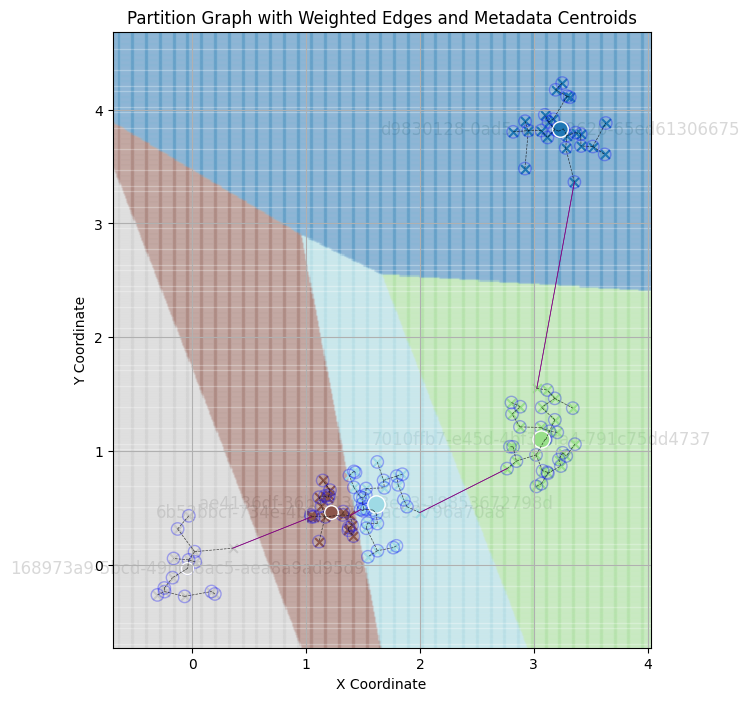

In [98]:
plot_partition_graph(partitions, edges, meta_data, inter_edges, clusters["clusters"])

In [ ]:
vectors[11]

[0.4691366163130478, 0.4915732838146507]

IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x0000025AFE54EAC0> (for post_execute), with arguments args (),kwargs {}:


TypeError: 'Figure' object is not iterable

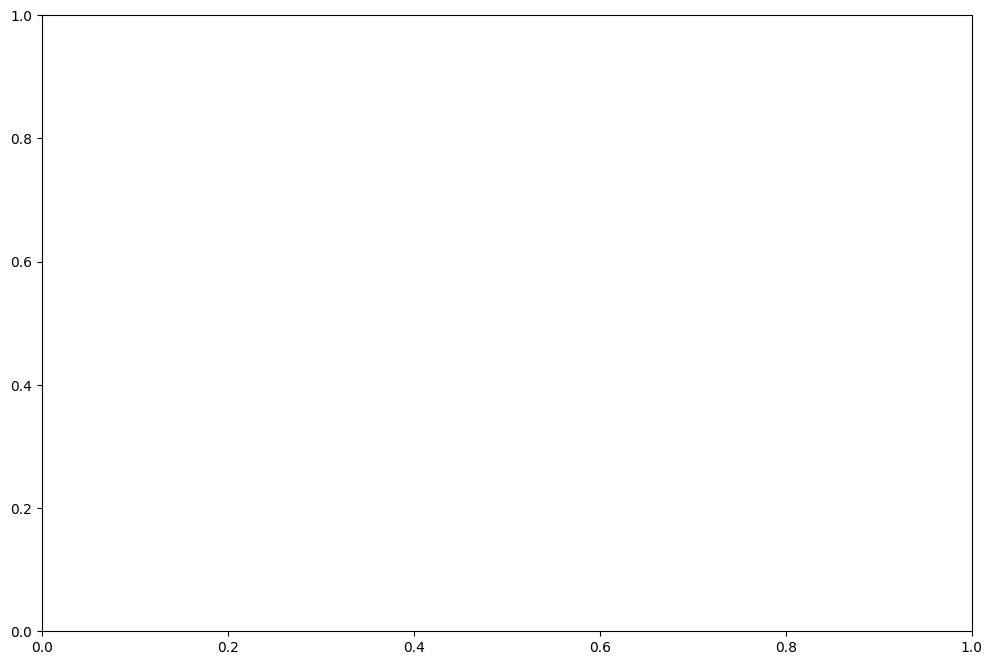

In [87]:

# Create an animation and save it as a GIF
fig, ax = plt.subplots(figsize=(12, 8))
def update_frame(i):
    ax.clear()
    plot_partition_graph(partitions, edges, meta_data, inter_edges)

ani = animation.ArtistAnimation(fig, frames, interval=500, repeat_delay=1000)
ani.save('partition_graph_animation.gif', writer='pillow')


In [ ]:
clusters

[Cluster(center=[0.1, 0.1], radius=0.05, num_points=100),
 Cluster(center=[0.7, 0.7], radius=0.2, num_points=30),
 Cluster(center=[0.4, 0.4], radius=0.15, num_points=50),
 Cluster(center=[0.9, 0.1], radius=0.1, num_points=80)]

In [ ]:

composite_cluster_centers

[[0.5, 0.5], [0.55, 0.55], [0.5, 0.6], [0.45, 0.55]]

In [ ]:
knn_query([3.,3.1], 40)

Response from '/knn': [("4bd2077a-3f7b-4b9e-82fb-3f6c59e13ae6", 0.06692436), ("19544792-e484-4dbe-8a36-85dc8468add8", 0.070927694), ("e0ef583e-c7c7-4b81-84f6-8ec7e3e93fa3", 0.10130589), ("5befcfe8-28f6-4140-9564-8a5b0db4e61f", 0.12982829), ("ea494ac0-46e7-4ee9-b6c5-aebdac735bc6", 0.15341382), ("6e4683f5-60a3-44c6-baee-d4762ea38dc5", 0.19784907), ("64632002-a280-4a8c-ade8-ad30ed481d1a", 0.23400816), ("043de385-b482-494d-ac18-fa3f7833dc52", 0.24140593), ("603f659f-a544-418a-b4a1-7726ddd59901", 0.24904238), ("94ee6dba-fca2-4ec0-a1e6-fdaf7ee89fea", 0.27426243), ("f4637e83-17a5-4002-a75e-18dbc0a48ab1", 0.32900795), ("e1ccc704-86c0-46da-94ba-a077261baee6", 0.36173552), ("8b5be516-8d47-4849-93cb-b996bbba2e20", 0.38943243), ("9377481f-3146-4864-adf5-216ea3559a09", 0.26793686), ("03ff4b9a-0a3e-4739-b64b-9a324adf8e2d", 0.30065754), ("2bc3c7a7-0eb7-4094-9796-d221df65f7cd", 0.33012173), ("41b9da52-8ecf-4f58-a113-3272c1d84a79", 0.34122235), ("382b902b-24e6-4d0f-87c0-4e134eebcdb9", 0.35944346), ("fc

'[("4bd2077a-3f7b-4b9e-82fb-3f6c59e13ae6", 0.06692436), ("19544792-e484-4dbe-8a36-85dc8468add8", 0.070927694), ("e0ef583e-c7c7-4b81-84f6-8ec7e3e93fa3", 0.10130589), ("5befcfe8-28f6-4140-9564-8a5b0db4e61f", 0.12982829), ("ea494ac0-46e7-4ee9-b6c5-aebdac735bc6", 0.15341382), ("6e4683f5-60a3-44c6-baee-d4762ea38dc5", 0.19784907), ("64632002-a280-4a8c-ade8-ad30ed481d1a", 0.23400816), ("043de385-b482-494d-ac18-fa3f7833dc52", 0.24140593), ("603f659f-a544-418a-b4a1-7726ddd59901", 0.24904238), ("94ee6dba-fca2-4ec0-a1e6-fdaf7ee89fea", 0.27426243), ("f4637e83-17a5-4002-a75e-18dbc0a48ab1", 0.32900795), ("e1ccc704-86c0-46da-94ba-a077261baee6", 0.36173552), ("8b5be516-8d47-4849-93cb-b996bbba2e20", 0.38943243), ("9377481f-3146-4864-adf5-216ea3559a09", 0.26793686), ("03ff4b9a-0a3e-4739-b64b-9a324adf8e2d", 0.30065754), ("2bc3c7a7-0eb7-4094-9796-d221df65f7cd", 0.33012173), ("41b9da52-8ecf-4f58-a113-3272c1d84a79", 0.34122235), ("382b902b-24e6-4d0f-87c0-4e134eebcdb9", 0.35944346), ("fc055467-0f2b-48e7-97fe